Your name: Huy Tran

Your student ID number: 33259590

Shared link to this notebook: https://github.com/hvtran21/cs446_p1

## Programming Assignment 1 (P1) for COMPSCI 446, Search Engines

In [3]:
version = 3 # DO NOT MODIFY. If notebook does not match with autograder version, the tests are likely fail!!

The purpose of this project is to explore tokenization, stopword removal, and stemming within a few real documents, and to investigate term statistics as related to Heaps' and possibly Zipf's Laws. Although actual time to complete this project will vary widely across students, expect to spend several hours if you are a strong programmer and 10+ hours if you're a bit rusty.

The description below is quite lengthy and will probably feel complicated at first, but each portion is just one piece of a sequence of rules that you need to apply to the tokens in the file. At a high level, the program will do the following:
* It will read in the (gzip compressed) input file and break it into tokens (loosely speaking, "words") using spaces or a fancier approach.
* It will optionally remove tokens that match stopwords in a provided list.
* It will optionally stem those tokens to their root form using a simple suffix-s stemmer or the Porter stemmer.
* It will calculate some statistics and summary information about the resulting tokens.
* It will generate incremental and cumulative information about the tokens the system encounters and generates.

Here are a list of provided files that will be loaded into your Google Drive for use in this notebook:

* _P1-train.gz_, a compressed file that you can use as input to your program.

* _PandP.gz_, which is a much larger text file for you to play with, though we will not provide any sample output. This is the text of Jane Austen's novel, _Pride and Prejudice_, downloaded from Project Gutenberg. You can see the original at https://www.gutenberg.org/ebooks/1342; what is provided below is the UTF-8 version, but with leading and trailing material removed, and with some unusual characters converted to ASCII equivalents (e.g., smart quotation marks, the British pound symbol).

* _stopwords.txt_ is a file containing the stopwords you will use in the stopping step.


Note, after the gradescope autograder is configured (**it is not ready yet**!), uploading the notebook file to gradescope will show the result on sample inputs. Please make sure the notebook is compilable (not only locally to your computer, but also on gradescope).

We first execute the following to connect to Google Drive (you will be prompted repeatedly for access to your Google Drive; please give it permission) and download copies of the sample files listed above. You should not need to make any modifications to the code, though if you want to use a slightly different path in Google Drive, you can modify the appropriate data_path value. (The autograder will not use your Google Drive.)

In [4]:
import os
import string
import gzip
import re

from collections import Counter

try:
    from google.colab import drive
    in_colab = True
except ImportError:
    in_colab = False


# You are more than welcome to code some helper functions.
# But do note that we are only grading functions that are coded in the template files.


# Connect to Google Drive and download copies of the sample files listed above.
# Please allow the access to your Google Drive or the following dataset loader will fail.
# (The autograder will not use your Google Drive.)
if in_colab:
  drive.mount("/content/drive/") ## DO NOT MODIFY THIS LINE
  data_path = "/content/drive/MyDrive/CS 446 Search Engines" ## CHANGE TO YOUR OWN FOLDER ON GOOGLE DRIVE
else:
  data_path = "./data/"  ## DO NOT MODIFY THIS LINE. CHANGING THIS LINE WOULD RESULT IN FAIL OF AUTOGRADER TESTS

### 0. Pre-processing

We will now load the texts that stored at <em>data_path</em> so that you can work with them in the rest of the notebook. We will not bother loading the files if they have already been loaded to your Google Drive, so this should be a one-time effort.

**NOTE**: This code will not create a new folder for you. It assumes that you have a folder called COMPSCI446 at the top level of your Google Drive. You can create that folder and everything will work fine. If you want to create something different (e.g., COMPSCI446-P1 or COMPSCI446/P1) then create that folder and edit the data_path line in the cell above.

This next step also loads the files into lists of strings so that you can use them directly elsewhere. That is, you do not need to open and read in the files yourself: it's done.

Note, in this assignment, to practice the tokenization process, we load the entire file directly into memory and then process it line by line. However, in the real-world scenario, when dealing with large dataset (saying billions of entries), it would be better to process the content line by line to save memory of the machine and/or because the whole file wouldn't even fit in memory.

In [5]:
import urllib.request
import gzip
from pathlib import Path

def load_file(file_path: str, gz_zip: bool = True) -> list[str]:
    """
    Load strings from the text or gzip file. Remember to strip newline if necessary!

    Args:
        file_path: the location of file we want to analyze on.
        gz_zip: true if the file is gzipped, false otherwise

    Returns: an array of string loaded from the text or gzip file.
    """
    webloc = "https://cs.umass.edu/~allan/cs446/"


    data_info = Path(data_path)
    if not data_info.exists() or not data_info.is_dir():
      print(f"Google folder \"{data_path}\" is not present or not a folder. Nothing will work from here.")
      return []

    local_google_drive_path = os.path.join(data_path,file_path)
    local_file = Path(local_google_drive_path)
    if local_file.is_file():
        print(f"File \"{file_path}\" already exists, not downloading.")
    else:
        print(f"Cannot find \"{file_path}\" so downloading it")
        urllib.request.urlretrieve(webloc + file_path, local_google_drive_path)
        print("Done")

    if not gz_zip:
        f = open(local_google_drive_path, "r", encoding="utf-8-sig")
    else:
        # Read compressed file (opened in text mode since that's what we use)
        f = gzip.open(local_google_drive_path, "rt", encoding="utf-8-sig")
    results = [line.strip("\n") for line in f.readlines() if line]

    if f:
      f.close()

    return results



# path to documents and stopwords
documents_path = "PandP.gz" # path to gzip file that contains documents
train_data_path = "P1-train.gz" # Path to p1 train dataset
stopwords_path = "stopwords.txt"  # path to the file that contains stopwords

sentences = load_file(documents_path)
train_sentences = load_file(train_data_path)
stopwords = load_file(stopwords_path, gz_zip = False)
print(f"First line of {documents_path:>16}: {sentences[0]}");
print(f"First line of {train_data_path:>16}: {train_sentences[0]}");
print(f"First line of {stopwords_path:>16}: {stopwords[0]}");

File "PandP.gz" already exists, not downloading.
File "P1-train.gz" already exists, not downloading.
File "stopwords.txt" already exists, not downloading.
First line of         PandP.gz:                          [Illustration:
First line of      P1-train.gz: First, here are all of the stopwords, none of which should make it through if yesStop is selected.
First line of    stopwords.txt: a


### 1. Tokenization

The first step of processing text is to break it into tokens. That will be either by using whitespace or two different fancier process. How you do that will be determined by the choice of tokenization function as follows.

Each of these functions accepts a string (in this case, a line/sentence from one of the input files) and will produce a list of tokens as strings. In all cases, the tokens should preserve their order within original documents and if extra tokens are generated, they should be in the corresponding position of the token that triggered their creation.

You can see how these (and other functions) are used by looking at the tokenization() function in section 4.1. Note that the autograder expects these functions to have the arguments as listed here.

#### 1.1 <u>tokenize_space()</u>

This tokenizer will break the input line into a list of whitespace-separated tokens. If there are multiple whitespace characters in a row (multiple spaces, a space and a tab, a space and a line break, etc.) they are treated as a single token break: e.g., "a&lt;space&gt;&lt;space&gt;b" is two tokens ("a" and "b") rather than three ("a", &lt;empty&gt;, "b"). Do not make any other changes to the tokens beyond separating them. So, for example, the start of this paragraph would result in the following 16 tokens (for the sake of space, listed across the line separated by ⍟, though that is not what you will actually do in your output):

    This ⍟ tokenizer ⍟ will ⍟ break ⍟ the ⍟ file ⍟ into ⍟ a ⍟ list ⍟ of ⍟ whitespace-separated ⍟ tokens.

Note that punctuation is included with a token based on where the whitespace is and tokens are produced without changing their case. There are very simple solutions to this: you can do this in one line.

In [6]:
def tokenize_space(input_str: str) -> list[str]:
    """
    Tokenize sentence into whitespace-separated tokens. For
    example, input_str = "2024 Fall Search Engine", the function
    should return ["2024", "Fall", "Search", "Engine"].

    Args:
        input_str: the sentence/phrase that we want to tokenize.

    Returns: an array of whitespace-separated tokens.
    """

    #########
    ##
    ## Implement the function here
    ##
    #########
    input_str = re.sub(r"\s+", " ", input_str.replace("\n", " ").replace("\t", " "))
    return input_str.split()

tokens_separated_by_space = tokenize_space(train_sentences[0])
print( f"Input string: \"{train_sentences[0]}\"" )
print(tokens_separated_by_space)

Input string: "First, here are all of the stopwords, none of which should make it through if yesStop is selected."
['First,', 'here', 'are', 'all', 'of', 'the', 'stopwords,', 'none', 'of', 'which', 'should', 'make', 'it', 'through', 'if', 'yesStop', 'is', 'selected.']


#### 1.2 tokenize_4grams()

This is another straightforward tokenizer, but one that does have as many ready solutions on hand. Unlike the one above, this one _treats spaces as part of the token_. Every four characters is a token, regardless of whether the characters are whitespace, punctuation, or alphanumeric characters. The one exception so that is that you should treat any white-space type character (newline or tab) as if it were a space. _In addition_, if there are multiple whitespace characters in a row (multiple spaces, a space and a tab, a space and a line break, etc.) they are treated as a single space: e.g., "a&lt;space&gt;&lt;space\>bc" is a single token ("a&lt;space&gt;bc") rather than the token "a&lt;space&gt;&lt;space&gt;b" and so on). Similarly, "a&lt;space&gt;&lt;newline&gt;&lt;tab&gt;bcef" should generate "a&lt;space&gt;bc" and "bcef".  

It turns out that in most applications we need to use "overlapping" n-grams. So you should start each token two characters after the previous one. Using the same notation as above, the sequence

    An  iced coffee \t
    is very nice

would generate the following sequence of tokens (using the same notation as above, with ⍟ showing where tokens break). Spaces are replaced with underscores so they are easier to see:

    An_i ⍟ _ice ⍟ ced_ ⍟ d_co ⍟ coff ⍟ ffee ⍟ ee_i ⍟ _is_ ⍟ s_ve ⍟ very ⍟ ry_n ⍟ _nic ⍟ ice

For the final token, do not include the 1-, 2-gram that ends that final token. And if the number of characters in the file is not a multiple of four, stop with the final 3-gram (like what we have in the example with _ice_ but not also _e_).

In special cases, if the string is too short to create even one 4-gram, you should return the original token instead.

In [7]:
import re
def tokenize_4grams(input_str: str) -> list[str]:
    """
    Tokenize sentence into 4char tokens with shifting windows. For example,
    input_str = "An\ticed coffee \t\nis very nice", the function should return
    ['An i', ' ice', 'ced ', 'd co', 'coff', 'ffee', 'ee i', ' is ', 's ve', 'very', 'ry n', ' nic', 'ice'].

    Args:
        input_str: the sentence/phrase that we want to tokenize.

    Returns: an array of 4-grams tokens.
    """

    #########
    ##
    ## Implement the function here
    ##
    #########
    if input_str == "":
        return [input_str]
    
    input_str = re.sub(r"\s+", " ", input_str.replace("\n", " ").replace("\t", " "))

    if len(input_str) == 1:
        return input_str
    
    return [input_str[i:i+4] for i in range(0, len(input_str)-2, 2)]

token_4grams = tokenize_4grams(sentences[0])

# Check if the output matches the example mentioned above
print(' ⍟ '.join([elem.replace(' ', '_') for elem in tokenize_4grams("An\ticed coffee \t\nis very nice")]))
print(' ⍟ '.join([elem.replace(' ', '_') for elem in tokenize_4grams("    ")]))
print(' ⍟ '.join([elem.replace(' ', '_') for elem in tokenize_4grams("First, here are all of the stopwords, none of which should make it through if yesStop is selected.")]))
print(' ⍟ '.join([elem.replace(' ', '_') for elem in tokenize_4grams("Finally, the rest of the text is designed to stress your fancy tokenizer. ")]))


An_i ⍟ _ice ⍟ ced_ ⍟ d_co ⍟ coff ⍟ ffee ⍟ ee_i ⍟ _is_ ⍟ s_ve ⍟ very ⍟ ry_n ⍟ _nic ⍟ ice
_
Firs ⍟ rst, ⍟ t,_h ⍟ _her ⍟ ere_ ⍟ e_ar ⍟ are_ ⍟ e_al ⍟ all_ ⍟ l_of ⍟ of_t ⍟ _the ⍟ he_s ⍟ _sto ⍟ topw ⍟ pwor ⍟ ords ⍟ ds,_ ⍟ ,_no ⍟ none ⍟ ne_o ⍟ _of_ ⍟ f_wh ⍟ whic ⍟ ich_ ⍟ h_sh ⍟ shou ⍟ ould ⍟ ld_m ⍟ _mak ⍟ ake_ ⍟ e_it ⍟ it_t ⍟ _thr ⍟ hrou ⍟ ough ⍟ gh_i ⍟ _if_ ⍟ f_ye ⍟ yesS ⍟ sSto ⍟ top_ ⍟ p_is ⍟ is_s ⍟ _sel ⍟ elec ⍟ ecte ⍟ ted.
Fina ⍟ nall ⍟ lly, ⍟ y,_t ⍟ _the ⍟ he_r ⍟ _res ⍟ est_ ⍟ t_of ⍟ of_t ⍟ _the ⍟ he_t ⍟ _tex ⍟ ext_ ⍟ t_is ⍟ is_d ⍟ _des ⍟ esig ⍟ igne ⍟ ned_ ⍟ d_to ⍟ to_s ⍟ _str ⍟ tres ⍟ ess_ ⍟ s_yo ⍟ your ⍟ ur_f ⍟ _fan ⍟ ancy ⍟ cy_t ⍟ _tok ⍟ oken ⍟ eniz ⍟ izer ⍟ er._


#### 1.2 <u>tokenize_fancy()</u>

This is a more complicated tokenizer that builds on the _spaces_ tokenizer (not the 4-gram version), applying the following additional rules. You can implement these rules in any way that makes sense to you as long as you honor the result of the rules as presented below, including dependencies between the rules. They are described on the assumption that you apply them as a sequence of steps in the order listed, though, and encourage you to do that rather than be clever.

*Hint: some of the steps generate new sequences that, in turn, need to be tokenized. You will probably want to think about a way to use recursion to handle that.*

1. Start with **ONE** space-separated token as in the <em>spaces </em>tokenizer above. (In reality, you'll do this for all of them. For simplicity we consider one at a time.)

1. A token that is a URL of the form "https://&hellip;" or "http://&hellip;" should be recognized as a single token. If there is trailing punctuation, it is not part of the URL and that punctuation should be discarded. Note that "https://hithere.com+https://howdy.org" should be considered as one simple token (since it starts with https). Also note that "446https://hithere.com" is _not_ a URL because it does not start with the URL signal. Make sure to handle the cases of "HTTP" and "HTTPS" (etc.) as the start of a url is case-insensitive. No other changes to a URL token should happen &ndash; i.e., for a URL, ignore the remaining rules below.

3. Convert the tokens to lowercase.
  
4. Treat numbers as a single token, including plus and/or minus signs, commas, and decimal points if they exist, so that "3,141.59" remains that string. A number can only be a sequence of numeric characters and those punctuation marks indicated <span class="" style="color: #98ca3e;">but it must have at least one number character. You do not have to validate that the number is well formed (so "3+14..1,59" and "-1-5" would both still be number tokens). Do no other processing to number tokens.

5. Apostrophes should be "squeezed out" so that it is as if they were never there. That means that a contraction such as "don't" would turn into "dont" and a name like "O'Brian" will become "obrian" (because it is was also lowercased in step 3).

6. Any remaining punctuation <u>other than periods and hyphens</u> should be treated as a word separator (as if it were white space: note the sequence of whitespace rules from the spaces tokenizer), except recall that punctuation in a URL (step 2) or number (step 4) is not a word break. So one token can generate multiple tokens: "3/11//23" will result in ["3", "11", "23"], and "3^rd" will result in ["3", "rd"], but "3.14/pi" will result in ["3.14", "pi"]. If a new token is a number (as defined above), do not process it further. So in the example, "3.14" will not be treated as an abbreviation by step 8. You may prefer to do this recursively to handle these rules on sub-parts. So that "b.c.," (note the comma) would result in "b.c." (remember that periods are not word breaks) and an empty token. A recursive call on "b.c." will result in "bc" from abbreviation rule 8 and the empty token will be discarded.

7. Hyphens (not treated as word separators) within a token should be processed in three steps: (1) remove the original token with its hyphen(s), (2) add new tokens with the hyphens treated as space separators (as in the spaces tokenizer), and then (3) add a new token with all hyphens squeezed out. So,

  ["data-base"] &rarr; ["data", "base", "database"]<br/>
  ["mother-in-law"] &rarr; ["mother", "in", "law", "motherinlaw"]<br/>
  ["a.-b.-c."] &rarr; ["a.", "b.", "c.", "a.b.c."]

  Note that as with the punctuation rule, the hyphen processing will result in additional tokens. Apply all tokenization rules to each of the tokens that are generated. So "1.-on-1." will generate ["1.", "on", "1.", "1.on.1."]. The occurrences of "1." will remain unchanged because they are numbers, but "1.on.1." will be treated as an abbreviation and converted into "1on1". There are some edge cases that will cause odd things to happen (e.g., the token "1-https://Some.Url" will end up converting the embedded URL to lowercase which contractadicts rule 2), but we won't stress about unusual subtokens caused by hyphens; we'll just accept and respect them for being what they are.

8. Treat abbreviations as a single token. If a token is not a number or URL and the only punctuation it contains is periods, it is an abbreviation. Note that this includes a token that comprises nothing but periods, even if that is not intuitive. For an abbreviation, remove all periods. So "i.b.m." converts to "ibm" and "Ph.D." and "Ph.D" both go to "phd" (because an abbreviation does not need to end with a period and because rule 3 converted it to lowercase). If the result of removing the periods is an empty string, then treat it as an empty token and do not report it out.

Here are some sample tokenizations that should happen:
* Token &rarr; token (lower case rule)
* She's &rarr; shes (apostrophe rule and lower case rule)
* Mother's-IN-Law &rarr; mothers, in, law, mothersinlaw (apostrophe, lowercase, hyphens)
* U.mass &rarr; umass (lowercase, abbreviation)
* go!!!!team &rarr; go team (non-period punctuation rule)
* USD\$10.30 &rarr; usd 10.30 (non-period punctuation, case, number)
* USD\$10,30 &rarr; usd 10 30 (not period punctuation, case)
* USD\$10-30 &rarr; usd 10-30 (not-period punctuation, number (not hyphen!!))

There will be interactions between rules, and that is OK. For example,
* ["a.-2./c."] &rarr; ["a.-2.", "c."] by non-period and non-hyphen punctuation rule
* &rarr; ["a.", "2.", "a.2.", "c."] by hyphen rule
* &rarr; ["a", "2.", "a2", "c"] after applying the abbreviation rule, noting that "2." is a number so retains its decimal point.

You may use a regular expression library to help identify patterns, but other third party libraries are <em>not </em>allowed for this part. You may, of course, use the standard libraries in Python.

In [8]:
import re
from string import punctuation

def check_url(token):
    if re.search(r"^(https?://)|^(HTTPS?://)", token):
        return True
    else:
        return False
    
def check_number(token):
    if re.search(r"[a-zA-Z]", token):
        return False
    if re.search(r"^([+-.,]*\d+|\d+[+-.,]*)+([+-.,]*\d*|\d*[+-.,])*([+-.,]*\d*|\d*[+-.,])+$", token):
        return True
    
    return False
    
def is_hyphen(token):
    hyphen_bytes = "-".encode("utf-8")
    for char in token:
        decoded_char = char.encode("utf-8")
        if hyphen_bytes == decoded_char:
            return True
    return False


def tokenize_fancy(input_token: str) -> list[str]:
    """
    Tokenize ONE token into tokens using the fancy rules defined.

    Args:
        input_token: the token that we want to tokenize.

    Returns: an array of sub-tokens in format,
        [
            sub_token_1_1,
            sub_token_1_2,
            ...
        ], or
        [
            'c',
            'a',
            '2.',
            'a2'
        ].
    """
    if input_token == "":
        return []
    
    if check_url(input_token):
        return [input_token.rstrip(punctuation)]  # remove trailing punctuation
    
    input_token = input_token.lower()

    if check_number(input_token):
        return [input_token]
    
    input_token = input_token.replace("'", "") # remove abbreviations
    final_tokens = []
    processed_tokens = []
    special_punctuation = punctuation.replace("-", "").replace(".", "")

    split_tokens = re.split(f"[{re.escape(special_punctuation)}]", input_token) # split on any punctation except period hyphens, words and numbers
    tokens = [token for token in split_tokens if token] # remove any empty strings

    for tok in tokens:
        if is_hyphen(tok) and not check_number(tok):  # its an actual hyphen, and the subtoken is not numbers
            hyphen_split = tok.split("-")
            for ele in hyphen_split:
                final_tokens.extend(tokenize_fancy(ele))   # recurisvely call on subtokens here
            final_tokens.append("".join(hyphen_split))
        else:
            final_tokens.append(tok)

    processed_tokens = []
    for tok in final_tokens:
        if '.' in tok and (re.search(r"[a-zA-Z]", tok) and not check_number(tok)) or tok == ".": # there is letters, there is a "." in it, and the subtoken is not a number
            sub_tokens = tokenize_fancy(tok.replace(".", ""))
            processed_tokens.extend(sub_tokens)
        else:
            processed_tokens.append(tok)

    return [tok for tok in processed_tokens if tok]
sample_sentence = 'a.-2./c. Ph.D. Ph. D. \'\'https://hithere.com+https://howdy.org!? https://noheading.com' 
# Check if the output matches the example mentioned above
for token in tokenize_space(sample_sentence):
  tokens_from_fancy_tokenization = tokenize_fancy(token)
  print(token, tokens_from_fancy_tokenization)
got = tokenize_space(" ".join(tokenize_fancy('"                                        d="M189.95,70.33a11.82,11.82,0,0,0-6.24-7,10.92,10.92,0,0,0-2.32-.52,89,89,0,0,0-44-44.07,10.82,10.82,0,0,0-.56-2.43,11.77,11.77,0,0,0-7-6.29,93.75,93.75,0,0,0-59.5,0,11.71,11.71,0,0,0-7,6.23,10,10,0,0,0-.54,2.32,88.78,88.78,0,0,0-44.06,44,11.62,11.62,0,0,0-2.46.57,11.8,11.8,0,0,0-6.28,7,93.72,93.72,0,0,0,0,59.49,11.74,11.74,0,0,0,6.22,7,11.74,11.74,0,0,0,2.33.51,88.93,88.93,0,0,0,44,44.09,11.59,11.59,0,0,0,.57,2.44,11.8,11.8,0,0,0,7,6.28,93.75,93.75,0,0,0,59.49,0,9.84,9.84,0,0,0,7.51-8.55,88.88,88.88,0,0,0,44.08-44,11.62,11.62,0,0,0,2.45-.54,11.81,11.81,0,0,0,6.27-7A93.79,93.79,0,0,0,189.95,70.33ZM135.12,30a78,78,0,0,1,35,35l-24,9.89a51.74,51.74,0,0,0-20.94-21ZM119,136.8a11.28,11.28,0,0,0-9.37-1.75,36.37,36.37,0,0,1-19.49,0,11.11,11.11,0,0,0-9.31,1.72,40.94,40.94,0,0,1-17.66-17.72,11.22,11.22,0,0,0,1.74-9.39,36.34,36.34,0,0,1,0-19.51,11.13,11.13,0,0,0-1.72-9.3A40.94,40.94,0,0,1,80.81,63.28,11.2,11.2,0,0,0,90.33,65a36.37,36.37,0,0,1,19.49,0,11.15,11.15,0,0,0,9.31-1.72A41,41,0,0,1,136.79,81a11.12,11.12,0,0,0-1.74,9.37,36.37,36.37,0,0,1,0,19.49,11.07,11.07,0,0,0,1.73,9.32A41,41,0,0,1,119,136.8Zm7.3-116.17.38.56-13.88,33a48.8,48.8,0,0,0-13.08-1.76A53.23,53.23,0,0,0,87,54L73.84,20.64A82.58,82.58,0,0,1,126.33,20.63ZM65,29.88l9.9,24a51.93,51.93,0,0,0-21,20.95L30,64.88A77.94,77.94,0,0,1,65,29.88ZM21.18,73.28l33,13.88A50.72,50.72,0,0,0,54,113L20.64,126.15a82.66,82.66,0,0,1,0-52.49ZM64.87,170a77.79,77.79,0,0,1-35-35l24-9.88a52,52,0,0,0,20.94,21Zm8.8,9.39-.39-.56,13.89-33a50.56,50.56,0,0,0,25.8.2l13.18,33.37A82.55,82.55,0,0,1,73.67,179.37Zm61.3-9.26-9.88-24a51.94,51.94,0,0,0,21-20.94L170,135.13A77.78,77.78,0,0,1,135,170.11Zm43.86-43.39-33-13.88A50.83,50.83,0,0,0,146,87l33.37-13.18a82.66,82.66,0,0,1,0,52.49Z">"')))
# should = ['11.82', '0', '0', '0-6.24-7', '10.92', '10.92', '0', '0', '0-2.32-.52', '89', '89', '0', '0', '0-44-44.07', '10.82', '10.82', '0', '0', '0-.56-2.43', '11.77', '11.77', '0', '0', '0-7-6.29', '93.75', '93.75', '0', '0', '0-59.5', '0', '11.71', '11.71', '0', '0', '0-7', '6.23', '10', '10', '0', '0', '0-.54', '2.32', '88.78', '88.78', '0', '0', '0-44.06', '44', '11.62', '11.62', '0', '0', '0-2.46.57', '11.8', '11.8', '0', '0', '0-6.28', '7', '93.72', '93.72', '0', '0', '0', '0', '59.49', '11.74', '11.74', '0', '0', '0', '6.22', '7', '11.74', '11.74', '0', '0', '0', '2.33.51', '88.93', '88.93', '0', '0', '0', '44', '44.09', '11.59', '11.59', '0', '0', '0', '.57', '2.44', '11.8', '11.8', '0', '0', '0', '7', '6.28', '93.75', '93.75', '0', '0', '0', '59.49', '0', '9.84', '9.84', '0', '0', '0', '7.51-8.55', '88.88', '88.88', '0', '0', '0', '44.08-44', '11.62', '11.62', '0', '0', '0', '2.45-.54', '11.81', '11.81', '0', '0', '0', '93.79', '0', '0', '0', '189.95', '78', '0', '0', '1', '35', '51.74', '0', '0', '11.28', '0', '0', '0-9.37-1.75', '36.37', '36.37', '0', '0', '1-19.49', '0', '11.11', '11.11', '0', '0', '0-9.31', '1.72', '40.94', '40.94', '0', '0', '1-17.66-17.72', '11.22', '11.22', '0', '0', '0', '1.74-9.39', '36.34', '36.34', '0', '0', '1', '0-19.51', '11.13', '11.13', '0', '0', '40.94', '0', '0', '1', '80.81', '63.28', '11.2', '11.2', '0', '0', '0', '90.33', '36.37', '0', '0', '1', '19.49', '0', '11.15', '11.15', '0', '0', '0', '41', '0', '0', '1', '136.79', '11.12', '0', '0', '0-1.74', '9.37', '36.37', '36.37', '0', '0', '1', '0', '19.49', '11.07', '11.07', '0', '0', '0', '1.73', '41', '0', '0', '1', '119', '48.8', '0', '0', '53.23', '0', '0', '0', '87', '82.58', '0', '0', '1', '126.33', '51.93', '0', '0', '0-21', '77.94', '0', '0', '1', '65', '50.72', '0', '0', '0', '54', '82.66', '0', '0', '1', '77.79', '0', '0', '52', '0', '0', '0', '20.94', '9.39-.39-.56', '50.56', '0', '0', '0', '82.55', '0', '0', '1', '73.67', '51.94', '0', '0', '0', '77.78', '0', '0', '1', '135', '50.83', '0', '0', '0', '146', '82.66', '0', '0', '1', '0', 'd', 'm18995', '7033a1182', '7033zm13512', '30a78', '989a5174', '1368a1128', '65a3637', '81a1112', '932a41', '33a488', '54l7384', '2064a8258', '2063zm65', '2988l99', '24a5193', '2095l30', '6488a7794', '2988zm2118', '7328l33', '1388a5072', '113l2064', '12615a8266', '170a7779', '21zm88', '2582l1318', '3337a8255', '13513a7778', '5249z', '6.27', '7a9379', '6277a9379', '35l', '24', '35l24', '0', '20.94', '21zm119', '0209421zm119', '0', '1.72', '93a4094', '017293a4094', '9.31', '172a41', '931172a41', '1368zm73', '116.17.38.56', '13.88', '1368zm731161738561388', '0', '13.08', '176a5323', '01308176a5323', '0', '5249zm6487', '05249zm6487', '1', '35', '35l24', '988a52', '13535l24988a52', '13.89', '33a5056', '138933a5056', '17937zm613', '9.26', '9.88', '24a5194', '17937zm61392698824a5194', '21', '2094l170', '212094l170', '17011zm4386', '43.39', '33', '1388a5083', '17011zm43864339331388a5083', '87l3337', '1318a8266', '87l33371318a8266']
# for token in should:
#     if token not in got:
#         print(token, "should've got")
# if got.sort() == should.sort(): print("yippie")

a.-2./c. ['a', '2.', 'a2', 'c']
Ph.D. ['phd']
Ph. ['ph']
D. ['d']
''https://hithere.com+https://howdy.org!? ['https', 'hitherecom', 'https', 'howdyorg']
https://noheading.com ['https://noheading.com']


Sample Result:

| Phrase | Tokens |
| :------ | :------ |
| a.-2./c. | ['c', 'a', '2.', 'a2'] |
| Ph.D. | ['phd' ] |
| Ph. | ['ph'] |
| D. | ['d'] |
| \'\'https://hithere.com+https://howdy.org!? | ['https', 'hitherecom', 'https', 'howdyorg'] |
| https://noheading.com | ['https://noheading.com'] |

### 2. Stopping
After tokenizing the input file, you will apply a stopword list or not. This function returns a version of the input tokens list with all of the stopwords omitted.

#### 2.1 <u>stopping()</u>
<u><strong>stopwords=None</strong></u>. means that you should not apply any stopping to the list. The result of this choice means that the token list will be unchanged by the stopping step.


<u><strong>stopwords=list[str]</strong></u>. means that you will use the list of words (that was loaded from the stopwords.txt file for you) as stopwords.

It doesn't appy in your coding of this function, but note that if an original token results in multiple tokens (spaces or non-period punctuation rules), you must apply the stopword list to <em>each of</em> the resulting tokens.

Also note that something that does not look like a stopword in the original text could become one &ndash; consider "a-n" in the text that will turn into ["a", "n", "an"] by the hyphen rule that will result in having "a" and "an" removed (if they're in the stopword list), but the "n" will be retained.

Those issues should be taken care of in the higher-level user of this function.

In [9]:
def stopping(input_tokens: list[str], stopwords: list[str] = None) -> list[str]:
    """
    Applying stopping to the list of tokens.

    Args:
        input_tokens: the list of tokens that we want to apply stopwords.
        stopwords: the list of stopwords that need to be removed from list of token.
            Default to None (an empty list), i.e., do not stop.

    Returns: an array of array of tokens in format,
        [
            sub_token_1_1,
            sub_token_1_2,
            ...
        ], or for example,
        [
            "a.-2./c.",
            "a",
            "2.",
            "c",
            "a2",
            "c"
        ].
    """

    #########
    ##
    ## Implement the function here
    ##
    #########

    for stop_word in stopwords:
        if stop_word in input_tokens: input_tokens.remove(stop_word)
    return input_tokens


# Recall that 'stopwords' is the contents of the stopwords file from way before
sample_sentence = 'a.-2./c. and hi'
for token in tokenize_space(sample_sentence):
    stop = stopping(
        tokenize_fancy(token), stopwords=stopwords
    )
    print(token, stop)


a.-2./c. ['2.', 'a2', 'c']
and []
hi ['hi']


Sample Result:

| Phrase | Tokens | Tokens After Stopping |
| :------ | :------ | :------ |
| a.-2./c. | ['c', '2.', 'a', 'a2'] | ['c', '2.', 'a2'] |
| and | ['and'] | [] |
| hi | ['hi'] | ['hi'] |

### 3. Stemming

After tokenizing the input file and possibly removing stopwords, you will stem each of the tokens in turn using one of three options. Note that stemming operates on every token that is not stopped, though in many cases (e.g., URLs, numbers, tokens that are already their stem) nothing will change. Also note that if a token generated multiple tokens (the spaces or non-period punctuation rules), the stemmer must be applied to each of them.

Both types of stemming accept a list of strings and return a stemmed copy. If the resulting stem is empty (can you see where that can happen?) just return an empty string for that token.

Note that we will put the full process together in 4.1 below when the _tokenization()_ function is defined.

<u><strong>stemming_type=None</strong></u>. means that you apply no stemming, so the token passes unchanged through this step. We will handle this directly in _tokenization()_ so you do not need to implement it.

#### 3.1 "Suffix s" stemming

<u><strong>stemming_type=suffix_s</strong></u>. means that you apply the "suffix s" stemmer, where if the final character of a token is "s" you remove the "s" and otherwise leave the token unchanged.

In [10]:
import re
def stemming_s(input_tokens: list[str]) -> list[str]:
    """
    Applying suffix-s stemming to the list of tokens.

    Args:
        input_tokens: the list of tokens that we want to perform stemming.

    Returns: an array of array of tokens in format,
        [
            sub_token_1_1,
            sub_token_1_2,
            ...
        ]

        For example, if the input is ["hi", "is", "this", "lass", "silly"] the output should be:
        [ "hi", "i", "thi", "las", "silly" ]
    """

    #########
    ##
    ## Implement the function here
    ##
    #########

    return [token[0:-1] if token and token[-1] == "s" else token for token in input_tokens]


sample_sentence = 'hi is this lass silly'
for token in tokenize_space(sample_sentence):
    stem = stemming_s(tokenize_fancy(token))  # Just tokenizes and skips stopping
    print(token, stem)


hi ['hi']
is ['i']
this ['thi']
lass ['las']
silly ['silly']


Sample Result:

| Phrase | Tokens |
| :------ | :------ |
| hi | ['hi'] |
| is | ['i'] |
| this | ['thi'] |
| lass | ['las'] |
| silly | ['silly'] |

#### 3.2 Stemming with Porter Stemmer

<u><strong>stemming_type=porter</strong></u>. means that you apply the Porter stemmer (we will use "the English stemmer" which is also called "Porter2"), though you will only implement part of the stemming algorithm. You'll find a description of the Porter2 stemmer in your textbook with Steps 1a and 1b listed. However, please use the following restatement of the algorithm where some of the ambiguities are clarified and where Step 1c is added for fun.

For each token in turn, apply the rule of Step 1a that matches the longest suffix (if it matches any) and then apply the one rule of Step 1b that matches the longest suffix (if any) of the output of Step 1a and then apply Step1c to Step 1b's result if it fits. In each step, if no suffix matches, do nothing and then continue to the next step.

    Vowels are a, e, i, o, and u.

As discussed in class (on Tuesday, September 17), the algorithm in the book talks about several things that are ill-defined as is. To address them, you need a method to determine a type of "structure" of the token being stemmed. Here that means figuring out how the token fits the pattern $[C](VC)^m[V]$ where $V$ is a sequence of one or more vowels (as above), C is a sequence of one or more consonents (anything that is not a vowel is a consonent; that includes punctuation), and $m$ indicates how often the $CV$ pattern repeats: if $m=0$ then it does not occur at all. Note that every word can be represented by this pattern. (Note that it's a weird concept for the 4-gram tokenizer. Treat the space as if it is a consonent.)

Here are some examples to help you verify you're doing the right thing:

* _agreed_ is _VCVC_ which is $(VC)^2$ with the leading $C$ and trailing $V$ empty.
* _retrieval_ is _CVCVCVC_ which is $C(VC)^3$ with the trailing $V$ empty.
* _feed_ is _CVC_ which is $C(VC)^1$ with the trailing $V$ empty.
* _tree_ is _CV_ which is $C(VC)^0V$ or $CV$ with nothing in the middle.

And now, on to the steps of the algorithm, reworked slightly from the description in the book for clarity. Recall that each step is looking at the _end_ of the word.

Step 1a:
  * Replace <em>sses</em> by <em>ss</em> (e.g., <em>stresses&rarr;stress</em>) and do nothing else for Step 1a.
  * If the stem ends with <em>ied</em> or <em>ies</em>, then if the remaining stem is _more than one_ character long, replace the ending by _i_, otherwise replace it by _ie_ (e.g., <em>ties&rarr;tie, cries&rarr;cri</em>). In either case, do nothing else for Step 1a.
  * If the stem ends in <em>us </em>or <em>ss </em>do nothing (e.g., <em>stress&rarr;stress</em>), including doing nothing else for Step 1a
  * If the stem ends with _s_, then "if the preceding stem part contains a vowel not immediately before the _s_" then delete the trailing _s_  (e.g., <em>gaps&rarr;gap</em> but <em>gas&rarr;gas</em>). And do nothing else for Step 1a. (Note that the "contains a vowel" bit is not helped by the $m$ rule described above. You'll need another way to check for that.)

Step 1b:
  * If the stem ends in <em>eed </em>or <em>eedly </em><u>then:</u>
      * if it is in the part of the stem after the first non-vowel following a vowel (i.e., if $m>1$ in the token that gets to 1b), replace it by <em>ee </em>(e.g., <em>agreed&rarr;agree, feed&rarr;feed</em>).
      * then go to step 1c
  * If the stem ends in <em>ed, edly, ing</em>, or <em>ingly </em>then:<u><strong> <br /></strong></u>
      * <u><strong></strong></u>if the preceding stem part <em>does not</em> contain a vowel, go to step 1c

      * if the preceding stem part <em>does</em> contain a vowel delete the ending <u><em>and then also consider the following three possibilities with the resulting stem:</em></u>
          * if the stem now ends in <em>at</em>, <em>bl</em>, or <em>iz </em>add _e_ (e.g., <em>fished &rarr; fish, pirating &rarr;pirate</em>) and go to step 1c

          * if the stem now ends with a double letter that is one of <em>bb, dd, ff, gg, mm, nn, pp, rr,</em> or <em>tt</em>, remove the last letter (e.g., <em>falling&rarr;fall, dripping&rarr;drip</em>) and go to step 1c

          * if the stem is now short (defined as $m=1$ for the stem after removing the suffix), add _e_ (e.g., <em>hoping&rarr;hope</em>) and go to step 1c.
             <!-- * Some example short words by this definition are <em>at </em>or <em>ow </em>(or "<em>or</em>"!). Surprisingly, <em>be</em> is not short because it is $CV = C(VC)^0V$, so $m=0$ which is not 1.
             * These stems are also short: <em>shed, shred, rap, trap, hop</em>, or <em>undo</em>, yet these are not: <em>pfft</em>, <em>eieio</em>, <em>to</em>, or <em>flu</em>). -->

Step 1c (not in the textbook):
  * If the stem ends in <em>y </em>and the character before the <em>y </em>is neither a vowel nor the first letter of the word, replace the <em>y </em>with an <em>i </em>(e.g., <em>cry&rarr;cri, bi&rarr;bi, bamby&rarr;bambi, bambi&rarr;bambi, say&rarr;say, why&rarr;whi</em>)

_Suggestion:_ You may find it useful to create helpful functions that implement each of the steps above. You don't have to, but since they act indepently and each step accepts a token/stem and then emits a new (or the same) token/stem, it might make things cleaner. To be clear: you can do anything you want to implement this, but you must have the function with the indicated arguments and result.


In [46]:
import re
from string import punctuation

def step_1b(token: str) -> str:
    new_str = token

#   -- start -- coveres steps with -eed or -eedly
    if re.search(r"eed$", token) and len(re.findall(r"[aeiou][^aeiou]", token.lower())) > 1:
        return step_1c(token[0:-3] + "ee")
    
    elif re.search(r"eed$", token) and len(re.findall(r"[aeiou][^aeiou]", token.lower())) <= 1:
        return step_1c(token)

    elif re.search(r"eedly$", token) and len(re.findall(r"[aeiou][^aeiou]", token.lower())) > 1:
        return step_1c(token[0:-5] + "ee")
    
    elif re.search(r"eedly$", token) and len(re.findall(r"[aeiou][^aeiou]", token.lower())) <= 1:
        return step_1c(token)
#   -- end -- 

# -- start -- covers steps with -ed -edly -ing or -ingly
    elif re.search(r"(ed$|edly$|ingly$|ing$)", token):
        new_str = re.sub(r"(ed$|edly$|ingly$|ing$)", "", token)
        if not re.search(r"[aeiou]", new_str.lower()):
            return step_1c(token)
            
        elif re.search(r"[aeiou]", new_str.lower()):
            if re.search(r"at$|bl$|iz$", new_str):
                return step_1c(new_str + "e")
            
            elif len(new_str) > 1 and new_str[-1] == new_str[-2] and new_str[-1] in "bdfgmnprt":
                return step_1c(new_str[0:-1])

            elif check_stem_short(new_str):
                return step_1c(new_str + "e")
        
    return step_1c(new_str)

def step_1a(token: str) -> str:
    if re.search(r"sses$", token):
        return token[0:-4] + "ss"
    
    elif re.search(r"^.{2,}(ied$|ies$)", token):
        remove_suffix = "".join(re.findall(r"^.{2,}(ied$|ies$)", token))
        return token[0:-len(remove_suffix)] + "i"
    
    elif re.search(r"^.{1}(ied$|ies$)", token):
        remove_suffix = "".join(re.findall(r"^.(ied$|ies$)", token))
        return token[0:-len(remove_suffix)] + "ie"
    
    elif re.search(r"ss$|us$", token):
        return token

    elif token and token[-1] == "s" and re.search(r"[aeiouAEIOU]+", token[0:-2]):
        return token[0:-1]
    
    return token

def step_1c(input_str: str) -> str:
    ret_str = input_str
    if re.search(r"^.+[^aeiouAEIOU]y$", input_str):
        ret_str = input_str[0:-1] + "i"
    return ret_str

def check_stem_short(input_str: str) -> bool:
    if re.search(r"[^aeiou]*[aeiou]*([aeiou][^aeiou]){1}[^aeiou]*[aeiou]*$", input_str.lower()) and len(re.findall(r"[aeiou][^aeiou]", input_str.lower())) == 1:
        return True
    return False

# def copy_and_remove_punctuation(input_str: str) -> tuple[str, str]:
#     find_punc = re.findall(f"[{re.escape(punctuation)}]", input_str)
#     return (input_str.rstrip("".join(find_punc)), "".join(find_punc))

def stemming_porter(input_tokens: list[str], need_stemming: bool = True) -> list[str]:
    """
    Applying stemming to the list of tokens.

    Args:
        input_tokens: the list of tokens that we want to apply stopping list
        need_stemming: whether we want to apply stem on the token list

    Returns: an array of array of tokens in format,
        [
            sub_token_1_1,
            sub_token_1_2,
            ...
        ], or
        [
            "a.-2./c.",
            "2.",
            "c",
            "a2",
            "c"
        ].
    """

    if need_stemming:
        modified_tokens = []
        for token in input_tokens:
            new_token = step_1a(token)
            modified_tokens.append(step_1b(new_token))

        return modified_tokens # You will return something before this statement
    else:
        return input_tokens

# sample_sentence = 'a.-2./c. cry pirating gas hopiNG agreeing USD$10-30 ruleS reSultS stress stopwords fishing stemming loving sheded 1Bonus abso-frigging-lutely learning source englishsource described "Embed designed Meetings examples wileyplus canvas videos. heap-3001039959.js'
# sample_sentence = '"https://www.wiley.com/college/wileyplus/images/resource_discovery_tool_50x50.png" wileyplus rules examples'


# for token in tokenize_space(sample_sentence):
#     stem = stemming_porter(
#         stopping(tokenize_fancy(token), stopwords=stopwords),
#         need_stemming=True
#     )
#     print(token, stem)

# sample_sentence = 'oringly "Embed tied cries ties blues hOping hOped hopING hopEd multi-tasking pre-setting fizzing fated faded receiving bless ties tied passes fried friends cry why say wing feeding rapping feed agreedly agreed'
# sample_sentence = 'oringly "Embed ties tied @!#$%^&*()123hoping cried gas blues falling feed arguing bias species bus'
# sample_sentence = 'oringly "Embed ties tied @!#$%^&*()123hoping 123cried gas blues falling feed arguing bias species bus why try sitting planned gases species bias tidy shed addressing classes atbliz tree ties'
# sample_sentence = 'stresses ties cries tied agreed retrieval pirating fished hopping falling dripping running fall hoped sitting plan planed gases gaps values bus species bias agreed seemly anxiously tidy feed tree shed undo trap hop running! !@#$%^&*()values species! ties!? feeding happiness cares !#stressless atbliz stress us gas miss bus less classes addressed'
# sample_sentence = '<script type="text/javascript" async="" src="446-canvas-page_files/heap-3001039959.js"></script>'
# sample_sentence = '<!DOCTYPE html> <html lang="en"> <head> <meta charset="UTF-8"> <title>Porter Stemmer Test</title> </head> <body><h1>Porter Stemmer Example</h1> <p>This is a test to see how well the Porter stemmer works with HTML content.</p> <p>The Porter stemmer is used to reduce words to their root form.</p><ul> <li>Stemming</li><li>Testing</li> <li>Algorithms</li> </ul> <p>Here"s a sample sentence: "Testing the Porter stemming algorithm to see how it performs."</p></body></html>'
# for token in tokenize_space("".join(train_sentences)):
#     stem = stemming_porter(
#         stopping(tokenize_fancy(token), stopwords=stopwords),
#         need_stemming=True
#     )
#     print(token, stem)
# sample_sentence = "'Embed"
# sample_sentence = """ { "name": "Embed Lucid Document", "=" "0" """
s = tokenize_space(sample_sentence)
for token in tokenize_space(sample_sentence):
    stem = stemming_porter(
        stopping(tokenize_fancy(token), stopwords=stopwords),
        need_stemming=True
    )
    print(token, stem)



7dd4b80918af0e0218ec0229e4bd5873js ['7dd4b80918af0e0218ec0229e4bd5873j']
heap-4123js ['heap', '4123js', 'heap4123j']


#### 4.1 Tokenization with or without stopping and stemming: <u>tokenization()</u>

<u>tokenization()</u> will tokenize a list of sentences given the option specified and return a list of processed token in the required format. Each element of the returned list (a tuple) will contain the original space-separated word and a list of token that are generated using the original space-separated word. So if fancy tokenization, normal stopping, and the Porter stemming are enabled, the sentences

    sentence 1: "whitespace-Separated" ⍟ tokens ⍟ (as ⍟ in ⍟ P0).
    sentence 2: And, ⍟ a.-2./c. ⍟ also.
    
where "⍟" indicates whitespace sequences, would result in

| Phrase | Tokens|
| :------- | :-------- |
|<span class="" style="color: #98ca3e;">"whitespace-Separated"| ["whitespace", "separate", "whitespaceseparate"] |
|<span class="" style="color: #98ca3e;">tokens| ["token"] |
|<span class="" style="color: #98ca3e;">(as| [] |
|<span class="" style="color: #98ca3e;">in| [] |
|<span class="" style="color: #98ca3e;">P0).| ["p0"] |
|<span class="" style="color: #98ca3e;">And,| [] |
|<span class="" style="color: #98ca3e;">a.-2./c.| ["2.", "c", "a2"] |
|<span class="" style="color: #98ca3e;">also.| ["also"] |


Several expectation as follows:
* The tokens must be listed in the order that the original tokens were encountered in the input file.
* If an original token is removed (e.g., stopped) nothing will be printed for that token (e.g., the line for <span class="" style="color: #98ca3e;">"(as", <span class="" style="color: #98ca3e;">"in", and <span class="" style="color: #98ca3e;">"And,").
* If an original token is transformed into additional tokens (e.g., because of hyphens) all of the new tokens will be listed on the same line (e.g., the hyphenated word and the weird <span class="" style="color: #98ca3e;">"a.-2./c." sequence).
* If a token is stemmed, the stem will be displayed with the original token. Note that the hyphenated word is separated, made into three tokens, and each of them is stemmed.
* Note that the process of tokenization with stopping and stemming can be executed as you read through the input file, though in this assignment we choose to read all the content in the file and then process it.

_NOTE:_ We are providing a solution to this function since all it does it call the functions you wrote above. The autograder will use this function, so although you can modify it if you want, be sure to properly handle all of the possible inputs and to produce output of the correct format.

In [12]:
def tokenization(
    input_list_str: list[str],
    stopwords: list[str] = None,
    tokenizer_type: str = None,
    stemming_type: str = None
) -> list[tuple[str, list[str]]]:
    """
    Tokenize the input sentences and apply stopping and stemming procedure to the tokenized sentences.

    Args:
        input_list_str: the list of sentences that we read from the input file.
        stopwords: the list of stopwords that need to be removed from list of token (omit to skip stopping)
        tokenizer_type: (case-insensitive) the tokenizer method that we want to apply on the token list.
              Options are ["space", "4grams", "fancy"].
              Default and unrecognized value(s) are considered as "space".
        stemming_type: (case-insensitive) the stemming method that we want to apply on the token list.
              Options are [None, "suffix_s", "porter"].
              Default and unrecognized value(s) are considered as None.

    Returns: an array of processed tokens (tokenized then stopped then stemmed as indicated) in required format, i.e.,
        [
            ("\"whitespace-Separate\"", ["whitespace", "separate", "whitespaceseparate"]),
            ("Tokens", ["token"]),
            ...
        ].
    """
    tokenizer_method = tokenize_space
    tokenizer_per_token_func = lambda x: [x]
    if tokenizer_type.lower() == "4grams":
      tokenizer_method = tokenize_4grams
    elif tokenizer_type.lower() == "fancy":
      tokenizer_per_token_func = tokenize_fancy


    stemming_method = lambda x: x # a function that returns its argument
    if stemming_type.lower() == "porter":
      stemming_method = stemming_porter
    elif stemming_type.lower() == "suffix_s":
      stemming_method = stemming_s


    recorder = []
    for input_str in input_list_str:  # every line
        recorder.extend(
            [
                (
                    token,
                    stemming_method(
                        stopping(tokenizer_per_token_func(token), stopwords=stopwords)),
                )
                for token in tokenizer_method(input_str)
            ]
        )

    return recorder


sample_sentences = ['a.-2./c. pirating', 'gas and hoping']
processed_tokens = tokenization(sample_sentences, stopwords=stopwords, tokenizer_type="fancy", stemming_type="porter")
for phrase, tokens in processed_tokens:
    print(phrase, tokens)
print()



a.-2./c. ['2.', 'a2', 'c']
pirating ['pirate']
gas ['gas']
and []
hoping ['hope']



Sample Result:

| Phrase | Tokens |
| :------ | :------ |
| a.-2./c. | ['c', '2.', 'a2'] |
| pirating | ['pirate'] |
| gas | ['gas'] |
| hoping | ['hope'] |

#### 4.2 Token Statistics - <u>heaps()</u>
<u>heaps()</u> analyzes the processed tokens and counts the number of unique tokens.

Do not count stopwords if they are being removed, but do count the extra words that hyphens and other non-period punctuations generate. The return should have the format:[ (10, 8), (20, 17), ... ], where the first component is the number of tokens you have generated so far and the second component is the number of those tokens so far if you remove duplicates.

For both counts, these are the tokens after the process of tokenizing, stopping, and stemming steps (indicated by the options in <u>tokenization()</u>), not before those steps. Clearly the second count will never be greater than the first.

To reduce the number of tuples you are generating by 90%, skip any pair where the first number is not a multiple of 10. Except always output the final pair (total number of tokens, total number of unique tokens) even if 10 does not divide it.

In [51]:
def heaps(processed_tokens: list[tuple[str, list[str]]]) -> list[tuple[int, int]]:
    """
    Analyze the processed tokens.

    Args:
        processed_tokens: the list of processed tokens in the expected format.

    Returns: an array of statistics in required format, i.e.,
        [
            (10, 8),
            (20, 17),
            ...
        ].
    """

    #########
    ##
    ## Implement the function here
    ##
    #########
    return_lst = []
    duplicate_set = set()
    count = 0

    for untokenized_token, tokens in processed_tokens:
        
        if tokens: # don't count stop words
            if count % 10 == 0 and count != 0 and (count, len(duplicate_set)) not in return_lst:
                return_lst.append((count, len(duplicate_set)))
        
            count += len(tokens)
            for tok in tokens:
                if tok not in duplicate_set:
                    duplicate_set.add(tok)
                    
    if (count, len(duplicate_set)) not in return_lst:
        return_lst.append((count, len(duplicate_set)))
    
    return return_lst

processed_tokens = tokenization(train_sentences, stopwords=stopwords, tokenizer_type="fancy", stemming_type="porter")
heaps_result = heaps(processed_tokens)
[print(curr) for curr in heaps_result[:10]];

(10, 10)
(20, 19)
(30, 27)
(40, 33)
(50, 42)
(60, 52)
(70, 60)
(80, 68)
(90, 77)
(100, 85)


#### 4.3 Token Statistics - <u>statistics()</u>

<u>statistics()</u> analyze the statistic of the processed tokens and return the following information in a tuple:
    <ul>
        <li>the first element is the total number of tokens you encountered</li>
        <li>the second is the total number of unique tokens you encountered</li>
        <li>the third element is an array contains the 100 most frequent final tokens you generated &ndash; i.e., after all of tokenizing, stopping, and stemming are done. Each element should have the format <code>[token, token_count]</code> where <code>token_count</code> is the number of occurrences of <code>token</code> you found. Sort them in descending order by the value of <code>token_count</code>. If there are multiple words with the same value of <code>token_count</code>, sort them alphabetically by <code>token</code>. If the same value of <code>token_num</code> happens for the 100th and 101st items, just stop at 100 with a tie breaker based on alphabetical order, for example, between (apple, 100) and (banana, 100), the result should be (apple, 100).</li>
    </ul>

Note that the first total number of tokens and unique tokens should match with the last element of the result of <u>heaps()</u>.
</div>

In [14]:
import heapq

def statistics(
    processed_tokens: list[tuple[str, list[str]]], top_k: int = 100
) -> tuple[int, int, list[tuple[str, int]]]:
    """
    Analyze the processed tokens.

    Args:
        processed_tokens: the list of processed tokens in the expected format.

    Returns:
        total number of tokens encountered;
        total number of unique tokens encountered;
        100 most frequent processed tokens encountered in required format, i.e.,
        [
            ("Test", 10),
            ("Token", 10),
            ("Apple", 9),
            ...
        ].
    """
    total_token_count = 0
    unique_token_count = 0
    duplicate_tokens = set()
    count_each_token = []

    for untokenized_token, tokens in processed_tokens:

        if tokens:
            total_token_count += len(tokens)    
            for token in tokens:
                if token not in duplicate_tokens:
                    unique_token_count += 1
                    duplicate_tokens.add(token)
                    count_each_token.append([token, 1])

                elif token in duplicate_tokens:
                    for tok_tup in count_each_token:
                        if tok_tup[0] == token:
                            tok_tup[1] = tok_tup[1] + 1
    
    count_each_token.sort(key=lambda tok_tup: tok_tup[0])
    count_each_token.sort(reverse=True, key=lambda tok_tup: tok_tup[1])

    #########
    ##
    ## Implement the function here
    ##
    #########

    return (total_token_count, unique_token_count, [(token, count) for token, count in count_each_token[0:100]])  # You will return something before this statement

processed_tokens = tokenization(sentences, stopwords=stopwords, tokenizer_type="fancy", stemming_type="porter")
stats_result = statistics(processed_tokens, top_k=100)
print(f"Overall Token Counts: {stats_result[0]}; Overall Unique Token Counts: {stats_result[1]}")
print("Top 10 frequent tokens with count:")
[print(curr) for curr in stats_result[2][:100]];

Overall Token Counts: 91492; Overall Unique Token Counts: 5819
Top 10 frequent tokens with count:
('her', 2294)
('i', 2121)
('she', 1752)
('not', 1500)
('you', 1375)
('his', 1303)
('had', 1186)
('but', 1041)
('have', 974)
('mr', 809)
('him', 777)
('my', 728)
('all', 652)
('elizabeth', 645)
('they', 610)
('so', 607)
('which', 569)
('been', 536)
('could', 531)
('no', 511)
('veri', 505)
('what', 494)
('would', 485)
('your', 478)
('this', 466)
('me', 462)
('their', 459)
('them', 445)
('darci', 432)
('will', 428)
('said', 406)
('such', 397)
('when', 389)
('do', 381)
('there', 373)
('if', 367)
('mrs', 354)
('bennet', 350)
('more', 337)
('much', 337)
('or', 327)
('am', 325)
('bingley', 316)
('miss', 315)
('must', 315)
('one', 304)
('jane', 302)
('than', 300)
('who', 298)
('sister', 294)
('ani', 283)
('other', 283)
('ladi', 281)
('did', 280)
('we', 268)
('should', 258)
('know', 254)
('though', 239)
('herself', 236)
('how', 235)
('never', 230)
('well', 230)
('before', 228)
('onli', 226)
('think

### 5. Analysis questions

#### 5.1
Run your code with fancy tokenization, stopping, and Porter stemming on <em>PandP.gz</em> and look at the statistics() output to see the most frequent terms from _Pride and Prejudice_. Print the most frequent 100 words and their counts out, sorted in descending order by count). Break ties around the 100th word by alphabetical order of the tokens. You can print them on one big line as long as the full list is visible, or you can print several of them per line.

After the list of terms, explain how the top terms are or are not relevant to the story or whether they seem like everyday words that aren't particularly related to the novel? Support your answer with examples (this is required). You may find it useful to skim the <a class="" href="https://en.wikipedia.org/wiki/Pride_and_Prejudice">summary on Wikipedia</a> to know what words are part of the story.

The top terms are relevant to the story, specifically the references to main characters like ('elizabeth', 645), ('darci', 432), and ('collin', 167) for example. In addition, the references to the main characters include the use of mr and mrs, ('mr', 809) and ('mrs', 354), showing the formalilty being used between the characters. Though there are a lot of words used like "connectors", there are enough terms that are used frequently such as the main characters, supporting that theres more words related to the novel rather than just being 'everyday' words (though not to discredit, there are still a lot of 'everyday' words).

#### 5.2
For this question, copy those same 100 words. Then say whether any of those top terms should have been stopwords (in your opinion)? Do the top terms or the list of all tokens suggest any changes to the tokenizing or stemming rules? What are they and why should they be made?

    Enter your answer here...

#### 5.3 Graph Comparison between result and Heaps' law - <u>graph_comparison()</u>

Figure 4.4. in the textbook (p. 82) displays a graph of vocabulary growth for the TREC GOV2 collection. The function <u>graph_comparison()</u> below should generate a similar graph which comparing the difference between the results of processed documents (from <u>heaps()</u>) and that of Heaps' Law. Try out some _K_ and _B_ values such that the produced line approximates the line comes from the dataset. This starts out considering what happens with the training data file.

_NOTE:_ We are providing the code for the graph generation. You will need to play around with _K_ and _B_ as just mentioned, but the graph generation is not something you need to figure out.

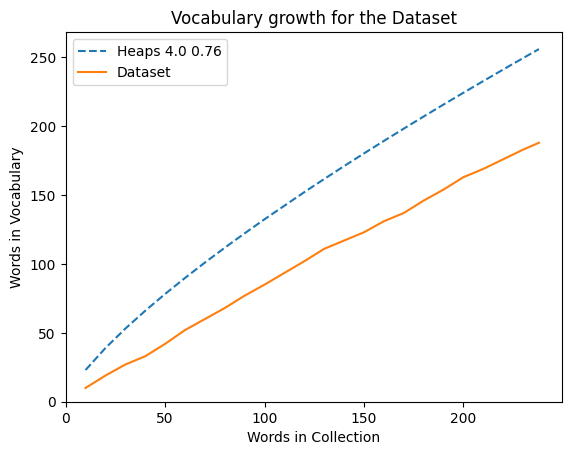

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def graph_comparison(heaps_result: list[tuple[int, int]], K: float, B: float) -> None:
    """
    Generates a graph that compares the results of processed documents and that of heaps' law.
    The curvature of heaps' law is computed using the function f(x) = K*x^B.

    Args:
        heaps_result: output from the heaps() function
        K: heaps' law parameter,
        B: heaps' law parameter.
    """
    heaps = np.array(heaps_result)

    X = heaps[:,0]
    dataset_y = heaps[:,1]
    heaps_y = [K * (elem ** B) for elem in X]

    _, ax = plt.subplots(1)
    ax.plot(X, heaps_y, "--", label=f"Heaps {K} {B}")
    ax.plot(X, dataset_y, label="Dataset")
    ax.set_title("Vocabulary growth for the Dataset")
    ax.set_xlabel("Words in Collection")
    ax.set_ylabel("Words in Vocabulary")
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    plt.legend()
    plt.show()



heaps_stuff = heaps(tokenization(train_sentences, stopwords=stopwords, tokenizer_type="fancy", stemming_type="porter"))

K = 4.0
B = 0.76
graph_comparison(heaps_result=heaps_stuff, K=K, B=B)

(5.3 continued)

Now go back and change the heaps_stuff so they are coming from the _Price and Prejudice_ data. You'll have to try different K and B values to see if you can find a fit. Do you feel that _Pride and Prejudice_ follows **Heaps' Law**? Why do you think so or think not? How did you decide on values of B and K?

Note: when selecting pages for the question, make sure to include the graph along with your answer.

    Enter your answer here


### 6. Extra credit

The following is an extra credit option for this assignment. Success on this part will possibly increase your score on P1. If you submit extra credit that does not work at all, you will lose one point on P1!

Your job for this option is to create a plot of how rank and occurrence counts relate to each other. To do generate the graph, it is probably easiest to copy the body of the graph_comparison() function above and edit it to handle Zift-related data and produce a Zipf graph.

Similar to the way the Heaps graph showed the K/B graph, you should show the ideal Zipf curve, too -- i.e., what the data would look like if it perfectly followed that law. Note that $c$ is a parameter to the function and a parameter of Zipf's Law.

In [16]:

def zipf_graph_comparison(stats_info: list[tuple[str, int]], c: float = None) -> None:
    """
    Generates a graph that compares the results of processed documents and that of zipf's law.
    The curvature of zipf's law is computed using the function f(x) = c/x, where x is the rank.

    Args:
        stats_info: the outputs from the statistics() function
        c: zipf's law parameter. Using rank 1's probability if not specified.
    """

    #########
    ##
    ## Implement the function here
    ##
    #########

stats_numbers = statistics(tokenization(train_sentences, stopwords=stopwords, tokenizer_type="fancy", stemming_type="porter"))

zipf_graph_comparison(stats_numbers)


Consider the graph generated above. Then say whether you feel that _Pride and Prejudice_ follows **Zipf's law**? Why do you think so or think not? Discuss your idea with some reasoning.

Note: when selecting pages for the question, make sure to include the graph along with your answer.

    Please enter your analysis of Zipf's Law here

### 7. Misc & Grading


**SUBMISSION INSTRUCTIONS**. P1 will be graded in two assignments within Gradescope. To start, be sure that your name and ID number and the URL for your notebook are listed at the top of your copy of the notebook.

1. The first, called P1, is the autograded part that will exercise your code, running a number of tests on the data you already have and then some tests on held-out data that you do not have access to. Go to gradescope and upload your notebook there.

1. The second,  called P1-analysis, is just for the various analysis questions. First make sure that your notebook has run all of the cells and that the output -- the open response questions toward the end and the graphs -- are visible. Then generate a PDF version of your notebook and upload the PDF to P1-analysis. (We'll post a reminder about how to generate the PDF to Piazza; you did it for X1 in case that helps remind you.) In this case, align your notebook to the analysis questions that are provided. Be sure that you include all of the pages that contain a particular question's answer and only pages that contain that particular question's answer.

Probably you'll repeat the first part until you're happy with it and then upload the second part when that's all done.

Your grade will be split into two parts, one from P1 and one from P1-analysis. They should add to 100 or 110 if you do the extra credit (and get full marks).


When you submit your code, the autograder will run:

* up to 18 possible combinations of the command line on the training input (3 tokenizers, 2 stemmers + not stemming, stopping or not)

* at least spaces-noStop-noStem and fancy-yesStop-porterStem on _Pride and Prejudice_

* at least fancy-yesStop-porterStem on a held-out evaluation set that you do not have

You may find a utility such as <em>diff</em> (Linux) helpful to compare your output to the expected output on <em>P1-train</em>, though it will require that write the output to a file. For the others, you'll have to eyeball it to see if it looks right. Or you may want to write a quick comparison function for your own use.

Some things that you might want to consider while coding and debugging:

* If you start with the <em>spaces</em> tokenizer and turn off stopping and stemming, you can check that this foundation step (breaking the text into space-separated tokens) works by a fairly simple examination. That happens to be the same as the spaces-noStop-noStem sample output for P1-train.

* Running the output of spaces tokenization through the stopping and stemming algorithms isn't likely to be very helpful for you (though we will grade it!) because the leftover punctuation reduces the number of times stemming occurs.

* You can compare spaces-noStop-noStem to fancy-noStop-noStem to see if your fancier tokenizer is working. You can look to see that numbers and URLs pass through unchanged, the hyphens and other punctuation behave as described, and so on.

* Then shift to fancy-yesStop-noStem to see if stopping is working

* And then fancy-yesStop-yesStem for see if the whole process works

* For this project, it does not matter if your code prints debugging information. It will be ignored by the autograder. The exceptions are around the analysis questions: try to keep those free of "clutter."